In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.io as sio

import torch
import torchvision
import torch.nn as nn   
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms

from PIL import Image

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

In [2]:

#Collecting, assembling & resizing images for training

#Resize Dimensions:
dim_x = 208
dim_y = 108

#RINDNet output paths
rindnet_path = "C:/Users/AmineSnoussi/Desktop/SST-Edge-Detection/src/RINDNet pipeline/RINDNet-main"  #Main RINDNet directory
mat_path = rindnet_path + "/run/rindnet"                           #Matrices path
depth_path = mat_path + '/depth/mat'                               #Depth matrices directory
illu_path = mat_path + '/illumination/mat'                         #Illumination matrices directory
normal_path = mat_path + '/normal/mat'                             #Normal matrices directory
reflectance_path = mat_path + '/reflectance/mat'                   #Reflectance matrices directory

#path for the training/validation data
output_training_path = "C:/Users/AmineSnoussi/Desktop/SST-Edge-Detection/Training_Dataset/training_set"
output_validation_path = "C:/Users/AmineSnoussi/Desktop/SST-Edge-Detection/Training_Dataset/validation_set"


#number of images
n=len(os.listdir(depth_path))
i = 0

# Loop over the images in the depth directory:
for image in os.listdir(depth_path):
    try:
        # Reading the mat files:
        depth = sio.loadmat(os.path.join(depth_path, image)).get("result")
        illu = sio.loadmat(os.path.join(illu_path, image)).get("result")
        normal = sio.loadmat(os.path.join(normal_path, image)).get("result")
        reflec = sio.loadmat(os.path.join(reflectance_path, image)).get("result")

        # Assembling the 4 frames:
        result = np.concatenate((depth, illu, normal, reflec), axis=1)

        # Arrays transformations:
        img_array = (255 * (1 - result)).astype(np.uint8)
        img = Image.fromarray(img_array)

        # Image resizing:
        img = img.resize((dim_x, dim_y))

        # Splitting the dataset in 2 (training/validation):
        if i % 2 == 0:
            output_path = output_training_path
        else:
            output_path = output_validation_path

        # Saving the image:
        os.makedirs(output_path, exist_ok=True)
        img.save(os.path.join(output_path, image.replace(".mat", ".jpg")))

        # Printing the evolution of the process:
        i += 1
        if i % (n // 100) == 0:
            print(f"{i}/{n} ({100*i/n:.2f}%)")
    except Exception as e:
        print(f"Error processing file: {image}. Error message: {e}")

print("Transformation complete!")


Error processing file: README.md. Error message: index out of range
Transformation complete!


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
from PIL import Image

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

class SSTDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.filenames = os.listdir(root_dir)

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        # Load the SST image from file
        filename = os.path.join(self.root_dir, self.filenames[idx])
        sst_image = Image.open(filename)

        # Convert the image to grayscale
        sst_image = sst_image.convert('L')

        # Apply the transformation
        sst_image = transform(sst_image)

        return sst_image

# Define the path to your SST images
data_path = 'C:/Users/AmineSnoussi/Desktop/SST-Edge-Detection/Training_Dataset/training_set'

# Create the dataset
sst_dataset = SSTDataset(data_path)

# Define the batch size for the dataloader
batch_size = 16

# Create the dataloader
dataloader = DataLoader(sst_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

# Get the number of samples in the dataset
num_samples = len(sst_dataset)

print(f'Number of samples in dataset: {num_samples}')


Number of samples in dataset: 1099


Batch 0: torch.Size([16, 1, 64, 64])


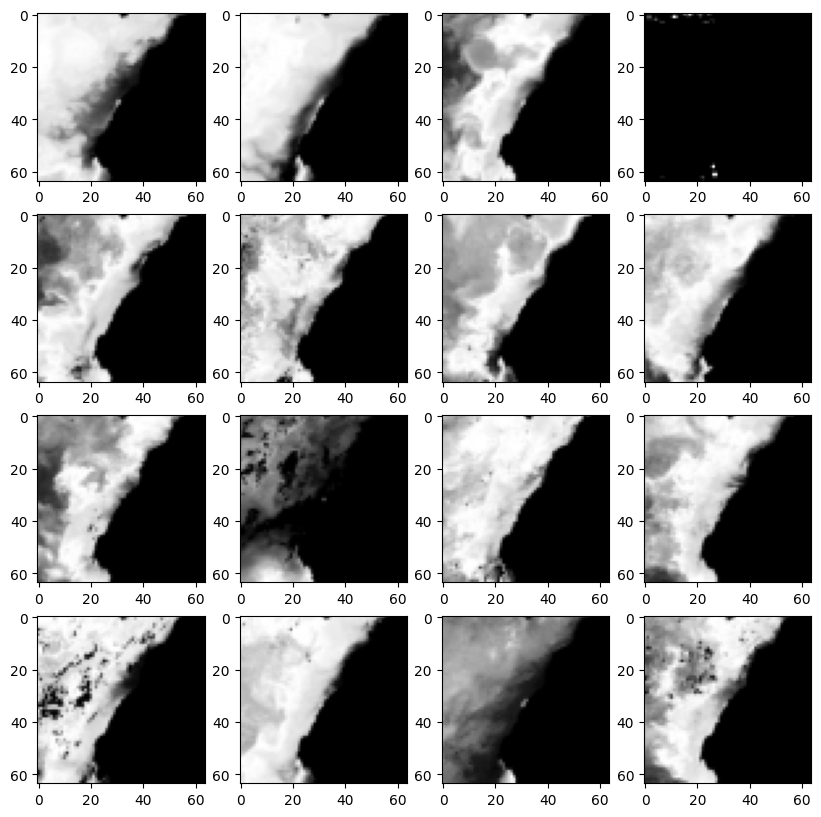

In [4]:
# Get the first batch of data
for i, batch in enumerate(dataloader):
    x = batch
    print(f"Batch {i}: {x.shape}")
    if i == 0:
        break

# Plot the first 16 images in the batch
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(10,10))
for i in range(batch_size):
    row = i // 4
    col = i % 4
    axs[row, col].imshow(x[i][0], cmap='gray')
plt.show()

In [5]:
import cv2

# Read the image
img = cv2.imread('C:/Users/AmineSnoussi/Desktop/SST-Edge-Detection/Training_Dataset/training_set/sst_0.png', cv2.IMREAD_GRAYSCALE)

# Apply Otsu's thresholding
thresh_value, thresh_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Display the thresholded image
cv2.imshow('Thresholded Image', thresh_img)
cv2.waitKey(0)
cv2.destroyAllWindows()
